In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from importlib import reload
from mppi import InputFiles as I, Calculators as C, Datasets as D

# Analysis of the main functionality of the package

We discuss some explicit example to describe the main features of the module

## InputFiles module :  construction of the pw input file

The Inputs module contains the PwIn class that allows us to built the input file of QuantumESPRESSO. 
The constructor of the class builds a the input object, the member of the class can be given and modified both using specific methods and/or by direct setting. 

Here we provide, as an example, the building of the input for Graphene:

In [2]:
input = I.PwIn()

In [3]:
k = 6
ecut = 80
a0 = 1.42
planeSep  = 10.0
A = [0.,0.,0.]
B = [0.,a0,0.]
a1 = [a0*np.sqrt(3),0.,0.]
a2 = [a0*np.sqrt(3)/2,a0*3./2,0.]
a3 = [0.,0.,planeSep]

input.set_calculation('scf')
input.set_pseudo_dir('../pseudos')
input.set_prefix('data')
input.system['ibrav'] = 0
input.cell_parameters =[a1,a2,a3]
input.set_atoms_type(1)
input.set_atoms_number(2)
input.set_atoms_position(pos_type='angstrom',pos_list=[['C',A],['C',B]])
input.atypes = {'C': [12.011,'C_pbe-20082014.UPF']}
input.set_convergence_thr(1e-8)
input.set_kpoints(ktype='automatic',kpoints=[k,k,1])
input.set_energy_cutoff(ecut)

print(input)

&control
           verbosity = 'high'
         calculation = 'scf'
          pseudo_dir = '../pseudos'
              prefix = 'data'
/&end
&system
               ibrav = 0
                ntyp = 1
                 nat = 2
             ecutwfc = 80
/&end
&electrons
            conv_thr = 1e-08
/&end
ATOMIC_SPECIES
   C   12.011   C_pbe-20082014.UPF
ATOMIC_POSITIONS { angstrom }
  C   0.0000000000   0.0000000000   0.0000000000
  C   0.0000000000   1.4200000000   0.0000000000
K_POINTS { automatic }
  6  6  1  0  0  0
CELL_PARAMETERS angstrom
  2.4595121467   0.0000000000   0.0000000000 
  1.2297560734   2.1300000000   0.0000000000 
  0.0000000000   0.0000000000  10.0000000000 



The input object can be written on file using the write method of PwIn

In [4]:
test_dir = 'test_dir'
if not os.path.isdir(test_dir): os.mkdir(test_dir)

In [5]:
input.write(test_dir+'/'+'input.in')

This class allows us also to create an instance of PwIn starting from an existing file

In [6]:
input2 = I.PwIn(test_dir+'/'+'input.in')
print(input2)

&control
           verbosity = 'high'
         calculation = 'scf'
          pseudo_dir = '../pseudos'
              prefix = 'data'
/&end
&system
               ibrav = 0
                ntyp = 1
                 nat = 2
             ecutwfc = 80
/&end
&electrons
            conv_thr = 1e-08
/&end
ATOMIC_SPECIES
   C   12.011   C_pbe-20082014.UPF
ATOMIC_POSITIONS { angstrom }
  C   0.0000000000   0.0000000000   0.0000000000
  C   0.0000000000   1.4200000000   0.0000000000
K_POINTS { automatic }
  6  6  1  0  0  0
CELL_PARAMETERS angstrom
  2.4595121467   0.0000000000   0.0000000000 
  1.2297560734   2.1300000000   0.0000000000 
  0.0000000000   0.0000000000  10.0000000000 



## InputFiles module :  construction of the Yambo input file

To build the input file the SAVE folder is needed by Yambo, so we use the yambo_test folder where a SAVE directory has been copied.

The approach used to deal with yambo input files is to call yamboIn with the specific run level. Yambo build a base input file that calls 'yambo.in'. The parameters of the input can be set and the updated file can be written on disk with its specific name.

In [9]:
fold = 'yambo_test'
fname = 'yambo_test.in'

y = I.YamboIn('yambo -x -V rl',folder=fold)
y['EXXRLvcs'] = [1000.0*20,'mHa']
krange = y['QPkrange'][0][:2]
kbandrange = krange + [1,10]
y['QPkrange'] = [kbandrange,'']
y.write(fold+'/'+fname)

In [10]:
print(y)

HF_and_locXC
FFTGvecs = 941.000000 RL
SE_Threads = 0.000000e+00 
EXXRLvcs = 20000.000000 mHa
% QPkrange
 1 | 4 | 1 | 10 |   
%



## Calculators module : a calculator object for QuantumESPRESSO

Initialize the calculator

In [7]:
code = C.QeCalculator(omp=1,mpi_run='mpirun -np 4',executable='pw.x',verbose=True,skip=False)

Initialize a qe calculator with command OMP_NUM_THREADS=1 mpirun -np 4 pw.x


Specifies the input object, the name of the file and the run_dir, if post_processing is True the .run returns an instance of the pw_out method of qepppy and contains the results of the computation

In [8]:
results = code.run(input=input,name='test',run_dir='pw_run',post_processing=True)

execute : cd pw_run ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp test.in > test.log


Extract the total energy (in Hartree)

In [9]:
results.E_tot

-11.40037440619968

A lot of quantities can be extracted from results, for instance

In [10]:
results.alat #atomic units = angstrom/0.529177211

4.647804377769

In [11]:
results.atoms_coord_cart # in which units ?????

array([[0.        , 0.        , 0.        ],
       [0.        , 2.68341111, 0.        ]])

No handles with labels found to put in legend.


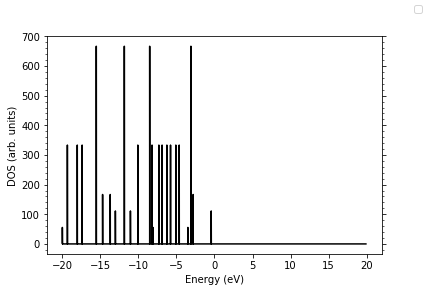

array([[-20.   ,   0.   ],
       [-19.999,   0.   ],
       [-19.998,   0.   ],
       ...,
       [ 19.998,   0.   ],
       [ 19.999,   0.   ],
       [ 20.   ,   0.   ]])

In [12]:
#pFile : option to enable/disable file save
#fname : output file name
results.density_of_states(pFile=False)

## Dataset module : how to manage several calculations

Show the functionality of this module by performing a convergence test for the ground state in function of the number of k-points and of the energy cutoff

In [13]:
code = C.QeCalculator(omp=1,mpi_run='mpirun -np 4',executable='pw.x',verbose=True,skip=True)

Initialize a qe calculator with command OMP_NUM_THREADS=1 mpirun -np 4 pw.x


In [14]:
study = D.Dataset(label='gs_convergence',run_dir='gs_convergence')

In [15]:
kpoints = [3,6,9,12]
ecut = [40,60,80,100]

In [16]:
for k in kpoints:
    for e in ecut:
        idd = {'k' : k, 'ecut' : e} 
        input.set_prefix(D.name_from_id(idd))
        input.set_kpoints(ktype='automatic',kpoints=[k,k,1])
        input.set_energy_cutoff(e)
        study.append_run(id=idd,calculator=code,input=input)

The paramaters of the dataset are given as follows, for instance

In [17]:
print(study.names)
print(study.ids)
print(study.calculators)
print(study.runs[3])

['ecut:40,k:3', 'ecut:60,k:3', 'ecut:80,k:3', 'ecut:100,k:3', 'ecut:40,k:6', 'ecut:60,k:6', 'ecut:80,k:6', 'ecut:100,k:6', 'ecut:40,k:9', 'ecut:60,k:9', 'ecut:80,k:9', 'ecut:100,k:9', 'ecut:40,k:12', 'ecut:60,k:12', 'ecut:80,k:12', 'ecut:100,k:12']
[{'k': 3, 'ecut': 40}, {'k': 3, 'ecut': 60}, {'k': 3, 'ecut': 80}, {'k': 3, 'ecut': 100}, {'k': 6, 'ecut': 40}, {'k': 6, 'ecut': 60}, {'k': 6, 'ecut': 80}, {'k': 6, 'ecut': 100}, {'k': 9, 'ecut': 40}, {'k': 9, 'ecut': 60}, {'k': 9, 'ecut': 80}, {'k': 9, 'ecut': 100}, {'k': 12, 'ecut': 40}, {'k': 12, 'ecut': 60}, {'k': 12, 'ecut': 80}, {'k': 12, 'ecut': 100}]
[{'calc': <mppi.Calculators.Calculators.QeCalculator object at 0x7fdae677cd68>, 'runs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}]
&control
           verbosity = 'high'
         calculation = 'scf'
          pseudo_dir = '../pseudos'
              prefix = 'ecut:100,k:3'
/&end
&system
               ibrav = 0
                ntyp = 1
                 nat = 2
             e

In [18]:
results = study.run(post_processing=True)

skip the computation for : ecut:40,k:3.log
skip the computation for : ecut:60,k:3.log
skip the computation for : ecut:80,k:3.log
skip the computation for : ecut:100,k:3.log
skip the computation for : ecut:40,k:6.log
skip the computation for : ecut:60,k:6.log
skip the computation for : ecut:80,k:6.log
skip the computation for : ecut:100,k:6.log
skip the computation for : ecut:40,k:9.log
skip the computation for : ecut:60,k:9.log
skip the computation for : ecut:80,k:9.log
skip the computation for : ecut:100,k:9.log
skip the computation for : ecut:40,k:12.log
skip the computation for : ecut:60,k:12.log
skip the computation for : ecut:80,k:12.log
skip the computation for : ecut:100,k:12.log


## Dataset module : post_processing of data

All the results of the dataset are stored in study.results as a dictionary

In [20]:
study.results

{0: <qepppy.qe.pw_out.pw_out at 0x7fdae67151d0>,
 1: <qepppy.qe.pw_out.pw_out at 0x7fdae6670f60>,
 2: <qepppy.qe.pw_out.pw_out at 0x7fdae66c3ef0>,
 3: <qepppy.qe.pw_out.pw_out at 0x7fdae6670550>,
 4: <qepppy.qe.pw_out.pw_out at 0x7fdae66e4048>,
 5: <qepppy.qe.pw_out.pw_out at 0x7fdae66c39e8>,
 6: <qepppy.qe.pw_out.pw_out at 0x7fdae6715208>,
 7: <qepppy.qe.pw_out.pw_out at 0x7fdae66e4c88>,
 8: <qepppy.qe.pw_out.pw_out at 0x7fdae679a1d0>,
 9: <qepppy.qe.pw_out.pw_out at 0x7fdae66d2d30>,
 10: <qepppy.qe.pw_out.pw_out at 0x7fdae6699eb8>,
 11: <qepppy.qe.pw_out.pw_out at 0x7fdae87b3b70>,
 12: <qepppy.qe.pw_out.pw_out at 0x7fdae66e4ba8>,
 13: <qepppy.qe.pw_out.pw_out at 0x7fdae6670eb8>,
 14: <qepppy.qe.pw_out.pw_out at 0x7fdae66d21d0>,
 15: <qepppy.qe.pw_out.pw_out at 0x7fdae6641438>}

To identify the correspondence between the element of study.results and the id, we have to look the position of the study in the ids list and select the associated element of the results dictionary

In [21]:
study.ids

[{'k': 3, 'ecut': 40},
 {'k': 3, 'ecut': 60},
 {'k': 3, 'ecut': 80},
 {'k': 3, 'ecut': 100},
 {'k': 6, 'ecut': 40},
 {'k': 6, 'ecut': 60},
 {'k': 6, 'ecut': 80},
 {'k': 6, 'ecut': 100},
 {'k': 9, 'ecut': 40},
 {'k': 9, 'ecut': 60},
 {'k': 9, 'ecut': 80},
 {'k': 9, 'ecut': 100},
 {'k': 12, 'ecut': 40},
 {'k': 12, 'ecut': 60},
 {'k': 12, 'ecut': 80},
 {'k': 12, 'ecut': 100}]

In [28]:
# For instance extract the total energy in two cases and compare with the values in the log files
# to check that the extraction procedure is correct
# energy of {'k': 3, 'ecut': 40}
print(2*study.results[0].E_tot)
# energy of {'k': 12, 'ecut': 80}
print(2*study.results[14].E_tot)

-22.70184777668358
-22.80443990263086


The fetch_results method of Dataset can be used to extract a quantity, for instance the total energy E_tot,for a subset of the Dataset elements specified by a dictionary, as follows

In [12]:
data=study.fetch_results(id={'ecut': 40},attribute='E_tot')
data

[-11.35092388834179,
 -11.37186320611442,
 -11.37341431882221,
 -11.37382494507814]

It can also be used to plot the usual convergence analysis

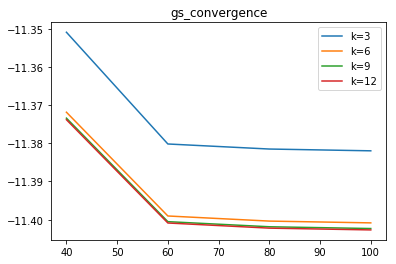

In [13]:
for k in kpoints:
    data=study.fetch_results(id={'k': k},attribute='E_tot')
    plt.plot(ecut,data,label='k='+str(k))
plt.title(study.label)
plt.legend()
plt.show()
    

## Dataset module : pre_processing function

In some cases it is useful to perform some preliminary operations before running a computation. For instance before performing a QE nscf computation we need copy of the scf save folder in the appropriate location, we have to prepare the SAVE folder before a Yambo computation.

For this reason we introduce a pre_processing function that perform the needed operations using the parameters passed to constructor of the dataset object. 

We discuss this functionality by considering a dataset of nscf computations peformed using a subset of values of kpoints and ecut previously defined. 

In [40]:
code = C.QeCalculator(omp=1,mpi_run='mpirun -np 4',executable='pw.x',verbose=True,skip=False)

Initialize a qe calculator with command OMP_NUM_THREADS=1 mpirun -np 4 pw.x


In [41]:
nscf_study = D.Dataset(label='nscf_analysis',run_dir='nscf',pre_processing='nscf',source_dir='gs_convergence')

The parameters for the pre_processing are stored in the kwargs elements of the class

In [46]:
nscf_study.kwargs

{'pre_processing': 'nscf', 'source_dir': 'gs_convergence'}

In [43]:
nscf_kpoints = [3,6,9]
nscf_ecut = 100

Append the chosen nscf computations to the dataset, note that the prefix of these computations have to be the same of the scf ones

In [44]:
input.set_calculation('nscf')
input.system['nbnd'] = 16

for k in nscf_kpoints:
    idd = {'k' : k, 'ecut' : nscf_ecut} 
    input.set_prefix(D.name_from_id(idd))
    input.set_kpoints(ktype='automatic',kpoints=[k,k,1])
    input.set_energy_cutoff(nscf_ecut)
    nscf_study.append_run(id=idd,calculator=code,input=input)

In [45]:
nscf_study.run()

nscf save folder already exsists. Save folder NOT COPIED
nscf save folder already exsists. Save folder NOT COPIED
nscf save folder already exsists. Save folder NOT COPIED
execute : cd nscf ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut:100,k:3.in > ecut:100,k:3.log
execute : cd nscf ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut:100,k:6.in > ecut:100,k:6.log
execute : cd nscf ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut:100,k:9.in > ecut:100,k:9.log


COMMENT : With this implementation of the pre_processing function the ids and prefix of the nscf dataset need to have the same structure of the scf ones, maybe this could be too restrictive in some cases....